In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import json
import os
from ast import literal_eval
from collections import defaultdict

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras import layers, models

import fastestimator as fe
from fastestimator.op import TensorOp
from fastestimator.op.numpyop import Minmax
from fastestimator.trace.io import ModelSaver
from fastestimator.util.compute_overlap import compute_overlap

In [3]:
WIDTH = 512
HEIGHT = 512
num_classes = 6+1

### Load SVHN data set

#### Once this is done we will use COCO data set.

In [4]:
from fastestimator.dataset import coco

In [5]:
# train_csv, test_csv, path = coco.load_data('/home/ubuntu/coco')
path = '/home/ubuntu/coco'
train_csv = os.path.join(path,'train_new.csv')
test_csv = os.path.join(path, 'val_new.csv')

In [6]:
df = pd.read_csv(train_csv)

In [7]:
df.head()

,image,image_id,label,x1,y1,x2,y2,label_set,select,label_new
0,/home/ubuntu/coco/train2014/COCO_train2014_000...,467311,"[2, 5, 7, 7]","[47, 307, 71, 46]","[250, 157, 131, 245]","[314, 640, 371, 317]","[365, 353, 299, 366]","{2, 5, 7}",True,"[0, 2, 4, 4]"
1,/home/ubuntu/coco/train2014/COCO_train2014_000...,496939,"[3, 3]","[17, 393]","[68, 93]","[416, 635]","[385, 313]",{3},True,"[1, 1]"
2,/home/ubuntu/coco/train2014/COCO_train2014_000...,353139,[3],[26],[353],[336],[618],{3},True,[1]
3,/home/ubuntu/coco/train2014/COCO_train2014_000...,96557,"[2, 2, 2, 3, 2, 2, 2, 2]","[326, 305, 355, 21, 302, 50, 143, 22]","[44, 42, 40, 72, 25, 48, 14, 56]","[480, 377, 431, 445, 410, 85, 324, 65]","[245, 98, 66, 504, 52, 61, 114, 89]","{2, 3}",True,"[0, 0, 0, 1, 0, 0, 0, 0]"
4,/home/ubuntu/coco/train2014/COCO_train2014_000...,155845,"[5, 7]","[310, 310]","[233, 230]","[368, 367]","[265, 266]","{5, 7}",True,"[2, 4]"


### Create a smaller data set

#### TFRecords generation at high resolution (800x1280) is super slow. I am creating a smaller data set.

In [8]:
train = pd.read_csv(train_csv)
test = pd.read_csv(test_csv)

In [9]:
# train_small = train[0:3000]
# train_small.to_csv(os.path.join(path,'train_small.csv'), index=False)
# test_small = test[0:50]
# test_small.to_csv(os.path.join(path,'test_small.csv'),index=False)
                   

### Plot image and bounding box
#### Note: I found that 30.png, 18522.png are not correct.

In [10]:
index = 2000

image        /home/ubuntu/coco/train2014/COCO_train2014_000...
image_id                                                 74984
label                                                      [2]
x1                                                         [4]
y1                                                       [177]
x2                                                       [108]
y2                                                       [284]
label_set                                                  {2}
select                                                    True
label_new                                                  [0]
Name: 2000, dtype: object

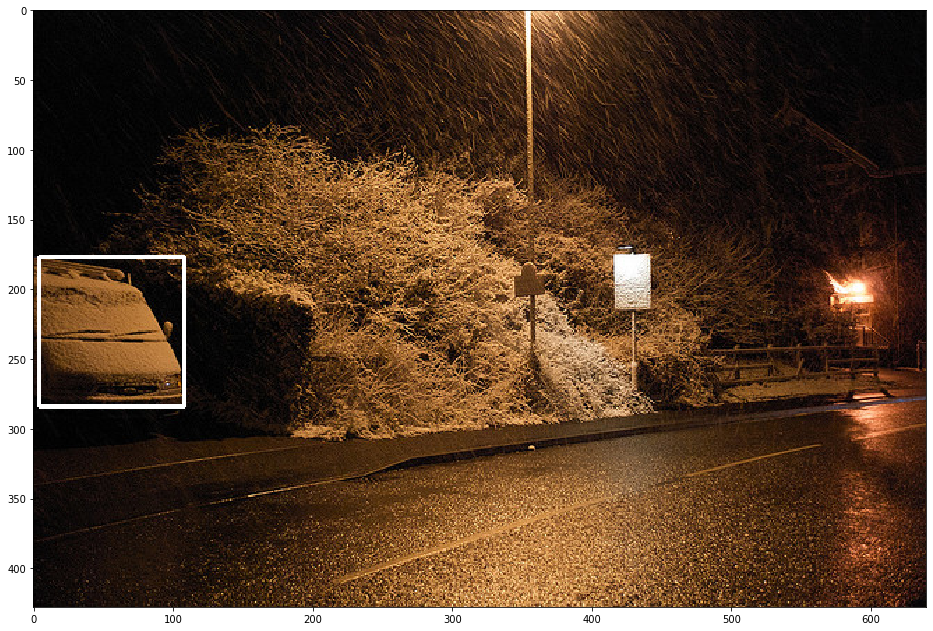

In [11]:
im = cv2.imread(os.path.join(path, df['image'][index]))
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(16,16))
# fig, ax = plt.subplots()
for box_index in range(len(literal_eval(df['label'][index]))):
    x1 = literal_eval(df['x1'][index])[box_index]
    y1 = literal_eval(df['y1'][index])[box_index]
    x2 = literal_eval(df['x2'][index])[box_index]
    y2 = literal_eval(df['y2'][index])[box_index]
    cv2.rectangle(im, (x1, y1), (x2, y2), (255, 255, 255), 2)
    
plt.imshow(im)
df.loc[index]

### Create tfrecord writer

In [12]:
from fastestimator.op import NumpyOp
from fastestimator.op.numpyop import ImageReader, Minmax, Resize
from fastestimator.util import RecordWriter

In [13]:
class String2List(NumpyOp):
    # this thing converts '[1, 2, 3]' into np.array([1, 2, 3])
    def forward(self, data, state):
        data = map(literal_eval, data)
        return data

In [14]:
class ResizeCocoStyle(Resize):
    def __init__(self, target_size, keep_ratio=False, inputs=None, outputs=None, mode=None):
        super().__init__(target_size, keep_ratio=keep_ratio, inputs=inputs, outputs=outputs, mode=mode)

    def forward(self, data, state):
        img, x1, y1, x2, y2 = data
        if self.keep_ratio:
            original_ratio = img.shape[1] / img.shape[0]
            target_ratio = self.target_size[1] / self.target_size[0]
            if original_ratio >= target_ratio:
                pad = (img.shape[1] / target_ratio - img.shape[0]) / 2
                pad_boarder = (np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int), 0, 0)
                y1 += np.ceil(pad).astype(np.int)
                y2 += np.ceil(pad).astype(np.int)
            else:
                pad = (img.shape[0] * target_ratio - img.shape[1]) / 2
                pad_boarder = (0, 0, np.ceil(pad).astype(np.int), np.floor(pad).astype(np.int))
                x1 += np.ceil(pad).astype(np.int)
                x2 += np.ceil(pad).astype(np.int)

            img = cv2.copyMakeBorder(img, *pad_boarder, cv2.BORDER_CONSTANT)
            
        img_resize = cv2.resize(img, (self.target_size[1], self.target_size[0]), self.resize_method)
        x1 = (np.array(x1) * self.target_size[1] / img.shape[1]).astype(np.int64)
        x2 = (np.array(x2) * self.target_size[1] / img.shape[1]).astype(np.int64)
        y1 = (np.array(y1) * self.target_size[0] / img.shape[0]).astype(np.int64)
        y2 = (np.array(y2) * self.target_size[0] / img.shape[0]).astype(np.int64)
        return img_resize, x1, y1, x2, y2

In [15]:
sample_array = np.array([[1,12,13],[14,5,6],[7,8,9]])
np.max(sample_array,axis=0)

array([14, 12, 13])

In [18]:
class GenerateTarget(NumpyOp):
    def __init__(self, inputs=None, outputs=None, mode=None, input_shape=(800, 800, 3)):
        super().__init__(inputs=inputs, outputs=outputs, mode=mode)
        self.pyramid_levels = [3, 4, 5, 6, 7]
        self.sizes = [32, 64, 128, 256, 512]
        self.strides = [8, 16, 32, 64, 128]
        self.ratios = np.array([0.5, 1, 2], dtype=np.float)
        self.scales = np.array([2**0, 2**(1.0 / 3.0), 2**(2.0 / 3.0)], dtype=np.float)

        self.anchors_list = np.zeros((0, 4))
        image_shapes = [(np.array(input_shape[:2]) + 2**pyra_level - 1) // (2**pyra_level)
                        for pyra_level in self.pyramid_levels]
        for idx, pyra_level in enumerate(self.pyramid_levels):
            base_size = self.sizes[idx]
            ratios = self.ratios
            scales = self.scales
            image_shape = image_shapes[idx]
            strides = self.strides[idx]
            anchors = self.generate_anchors_core(base_size, ratios, scales)
            shifted_anchors = self.shift(image_shape, strides, anchors)
            self.anchors_list = np.append(self.anchors_list, shifted_anchors, axis=0)

    def forward(self, data, state):
        label, x1, y1, x2, y2, image = data
        target_cls, target_loc = self.get_target(self.anchors_list, label, x1, y1, x2, y2, num_classes= num_classes) # 10 classes + bg
        return target_cls, target_loc, self.anchors_list

    def get_target(self, anchorbox, label, x1, y1, x2, y2, num_classes= num_classes):  # this is 80 not 81
        bg_index = num_classes - 1
        query_box = np.zeros((0, 4))
        query_label = np.zeros((0))
        for _x1, _y1, _x2, _y2, _label in zip(x1, y1, x2, y2, label):
            query_box = np.append(query_box, np.array([[_x1, _y1, _x2, _y2]]), axis=0)
            query_label = np.append(query_label, _label)

        overlap = compute_overlap(anchorbox.astype(np.float64), query_box.astype(np.float64))
        
        gt_argmax_overlaps_inds = np.argmax(overlap, axis=0)
        gt_max_overlaps = np.max(overlap, axis=0)
        for i,(elem_gt_argmax_overlap_ind, elem_gt_max_overlap) in enumerate(zip(gt_argmax_overlaps_inds, gt_max_overlaps)):
            overlap[elem_gt_argmax_overlap_ind, i]=1.0
            
        
        argmax_overlaps_inds = np.argmax(overlap, axis=1)
        max_overlaps = overlap[np.arange(overlap.shape[0]), argmax_overlaps_inds]
        positive_index = (max_overlaps > 0.5)
        ignore_index = (max_overlaps > 0.4) & ~positive_index
        negative_index = (max_overlaps <= 0.4)

        target_loc = get_loc_offset(query_box[argmax_overlaps_inds, :], anchorbox)
        target_cls = query_label[argmax_overlaps_inds]
        target_cls[negative_index] = bg_index
        target_cls[ignore_index] = -2  # ignore this example

        return target_cls, target_loc

    def generate_anchors_core(self, base_size, ratios, scales):
        num_anchors = len(ratios) * len(scales)
        # initialize output anchors
        anchors = np.zeros((num_anchors, 4))
        # scale base_size
        anchors[:, 2:] = base_size * np.tile(scales, (2, len(ratios))).T

        # compute areas of anchors
        areas = anchors[:, 2] * anchors[:, 3]

        # correct for ratios
        anchors[:, 2] = np.sqrt(areas / np.repeat(ratios, len(scales)))
        anchors[:, 3] = anchors[:, 2] * np.repeat(ratios, len(scales))

        # transform from (x_ctr, y_ctr, w, h) -> (x1, y1, x2, y2)
        anchors[:, 0::2] -= np.tile(anchors[:, 2] * 0.5, (2, 1)).T
        anchors[:, 1::2] -= np.tile(anchors[:, 3] * 0.5, (2, 1)).T

        return anchors

    def shift(self, image_shape, stride, anchors):
        shift_x = (np.arange(0, image_shape[1]) + 0.5) * stride
        shift_y = (np.arange(0, image_shape[0]) + 0.5) * stride
        shift_x, shift_y = np.meshgrid(shift_x, shift_y)

        shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()

        A = anchors.shape[0]
        K = shifts.shape[0]
        all_anchors = (anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
        all_anchors = all_anchors.reshape((K * A, 4))

        return all_anchors

### Util functions

In [59]:
sample_arr =np.random.randint(0,90,(100,5))
sample_arr

array([[24, 85, 15, 74, 53],
       [17, 85, 11, 54, 56],
       [51, 72,  6,  0,  6],
       [64, 74, 22, 35, 56],
       [24, 60,  3, 21,  2],
       [15, 60, 80, 19, 45],
       [38, 11, 17, 37, 10],
       [20, 89, 85, 63, 19],
       [46, 82, 51, 26,  7],
       [41, 32, 79, 47, 30],
       [51, 84, 48, 39, 31],
       [50, 69, 42, 18, 68],
       [40, 49, 66, 86, 10],
       [46, 12, 83, 74, 51],
       [ 1, 69, 72, 56,  5],
       [52,  2, 75, 83, 79],
       [60,  9, 63, 46, 65],
       [52, 85, 13, 42, 79],
       [78, 39, 14,  6, 56],
       [66, 13, 11, 23,  3],
       [21, 54, 21, 86, 78],
       [77, 21, 56, 69, 77],
       [52, 27, 75, 63, 12],
       [37,  9, 25, 49, 24],
       [39, 59, 28, 30, 20],
       [15, 86, 24,  2, 75],
       [89, 37, 68, 40, 78],
       [86, 21, 44, 58, 53],
       [16, 84, 39, 34, 75],
       [50, 57, 29, 76, 24],
       [35, 82, 24, 15, 69],
       [50, 26, 10, 18, 73],
       [27, 65, 71, 23, 41],
       [73, 32, 66, 82, 42],
       [25,  2

In [60]:
sample_arr[, 0]

array([24, 85,  6, 35,  2])

In [19]:
def get_loc_offset(box_gt, box_anchor):
    mean = 0
    std = 0.2
    anchor_width_height = np.tile(box_anchor[:, 2:] - box_anchor[:, :2], [1, 2])
    delta = (box_gt - box_anchor) / anchor_width_height
    return (delta -mean) / std

### Record writer

In [20]:
writer = RecordWriter(
    train_data=os.path.join(path, 'train_new.csv'),
    validation_data=os.path.join(path, 'val_new.csv'),
    save_dir=os.path.join(path, 'tfrecords'),
    ops=[
        ImageReader(inputs='image', outputs='image', parent_path=path),
        String2List(inputs=["label_new", "x1", "y1", "x2", "y2"], outputs=["label_new", "x1", "y1", "x2", "y2"]),
        ResizeCocoStyle((HEIGHT, WIDTH),
                        keep_ratio=True,
                        inputs=["image", "x1", "y1", "x2", "y2"],
                        outputs=["image", "x1", "y1", "x2", "y2"]),
        Minmax(inputs="image", outputs="image"),
        GenerateTarget(inputs=["label_new", "x1", "y1", "x2", "y2", "image"],
                       outputs=["target_cls", "target_loc", "base_loc"],
                       input_shape=(HEIGHT, WIDTH, 3))
    ])

### Pipeline

In [21]:
pipeline = fe.Pipeline(data=writer, batch_size=8, padded_batch=True, read_feature=["image", "image_id", "target_cls", "target_loc","base_loc"])

In [22]:
# !rm -rf /home/ubuntu/coco/tfrecords/

In [23]:
batch_data = pipeline.show_results(mode='train')

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 2630 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 1309 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json


In [24]:
# batch_data[0]['image'].shape

In [25]:
batch_data[0].keys()

dict_keys(['image', 'target_loc', 'target_cls', 'base_loc', 'image_id'])

In [26]:
# batch_data[0]['base_loc'][1]

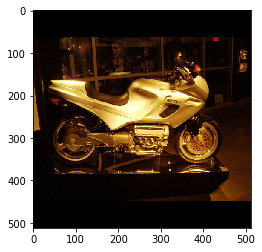

In [27]:
batch_index = 0
im = batch_data[0]['image'].numpy()[batch_index]
fig, ax = plt.subplots()
# for box_index in range(len(batch_data[0]['x1'].numpy()[batch_index])):
#     x1 = batch_data[0]['x1'].numpy()[batch_index][box_index]
#     y1 = batch_data[0]['y1'].numpy()[batch_index][box_index]
#     x2 = batch_data[0]['x2'].numpy()[batch_index][box_index]
#     y2 = batch_data[0]['y2'].numpy()[batch_index][box_index]
#     if x1 > 0:
#         im = cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)
ax.imshow(im)

### Keras definitions

#### Classification head

In [28]:
def classification_sub_net(num_classes, num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(num_classes * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='sigmoid',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer=tf.initializers.constant(np.log(1 / 99))))
    model.add(layers.Reshape((-1, num_classes)))  # the output dimension is [batch, #anchor, #classes]
    return model

### Regression head

In [29]:
def regression_sub_net(num_anchor=9):
    model = models.Sequential()
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(256,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      activation='relu',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(
        layers.Conv2D(4 * num_anchor,
                      kernel_size=3,
                      strides=1,
                      padding='same',
                      kernel_initializer=tf.random_normal_initializer(stddev=0.01),
                      bias_initializer='zeros'))
    model.add(layers.Reshape((-1, 4)))  # the output dimension is [batch, #anchor, 4]
    return model


## Define RetinaNet


In [30]:
def RetinaNet(input_shape, num_classes, num_anchor=9):
    inputs = tf.keras.Input(shape=input_shape)
    # FPN
    #     weights = '/home/ubuntu/ResNet-50-model.keras.h5'
    resnet50 = tf.keras.applications.ResNet50(weights="imagenet", include_top=False, input_tensor=inputs, pooling=None)
    #     resnet50.load_weights(weights, by_name=True)
    assert resnet50.layers[80].name == "conv3_block4_out"
    C3 = resnet50.layers[80].output
    assert resnet50.layers[142].name == "conv4_block6_out"
    C4 = resnet50.layers[142].output
    assert resnet50.layers[-1].name == "conv5_block3_out"
    C5 = resnet50.layers[-1].output
    
    P5 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C5)
    P5_upsampling = layers.UpSampling2D()(P5)
    P4 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C4)
    P4 = layers.Add()([P5_upsampling, P4])
    P4_upsampling = layers.UpSampling2D()(P4)
    P3 = layers.Conv2D(256, kernel_size=1, strides=1, padding='same')(C3)
    
    P3 = layers.Add()([P4_upsampling, P3])
    
    P6 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P6")(C5)
    P7 = layers.Activation('relu')(P6)
    P7 = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', name="P7")(P7)
    P5 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P5")(P5)
    P4 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P4")(P4)
    P3 = layers.Conv2D(256, kernel_size=3, strides=1, padding='same', name="P3")(P3)
    # classification subnet
    cls_subnet = classification_sub_net(num_classes=num_classes, num_anchor=num_anchor)
    P3_cls = cls_subnet(P3)
    P4_cls = cls_subnet(P4)
    P5_cls = cls_subnet(P5)
    P6_cls = cls_subnet(P6)
    P7_cls = cls_subnet(P7)
    cls_output = layers.Concatenate(axis=-2)([P3_cls, P4_cls, P5_cls, P6_cls, P7_cls])
    # localization subnet
    loc_subnet = regression_sub_net(num_anchor=num_anchor)
    P3_loc = loc_subnet(P3)
    P4_loc = loc_subnet(P4)
    P5_loc = loc_subnet(P5)
    P6_loc = loc_subnet(P6)
    P7_loc = loc_subnet(P7)
    loc_output = layers.Concatenate(axis=-2)([P3_loc, P4_loc, P5_loc, P6_loc, P7_loc])
    return tf.keras.Model(inputs=inputs, outputs=[cls_output, loc_output])

## Define loss

In [31]:
from fastestimator.op.tensorop import Loss

In [32]:
class RetinaLoss(Loss):
    def focal_loss(self, cls_gt_example, cls_pred_example, num_classes, alpha=0.25, gamma=2.0):
        bg_index = num_classes - 1
        # cls_gt has shape [A], cls_pred is in [A, K]
        # gather the objects and background, discard the rest
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        obj_bg_idx = tf.where(tf.greater_equal(cls_gt_example, 0))
        obj_bg_count = tf.cast(tf.shape(obj_bg_idx)[0], tf.float32)
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        cls_gt_example = tf.one_hot(cls_gt_example, num_classes)
        cls_gt_example = tf.gather_nd(cls_gt_example, obj_bg_idx)
        cls_pred_example = tf.gather_nd(cls_pred_example, obj_bg_idx)
        cls_gt_example = tf.reshape(cls_gt_example, (-1, 1))
        cls_pred_example = tf.reshape(cls_pred_example, (-1, 1))
        # compute the focal weight on each selected anchor box
        alpha_factor = tf.ones_like(cls_gt_example) * alpha
        alpha_factor = tf.where(tf.equal(cls_gt_example, 1), alpha_factor, 1 - alpha_factor)
        focal_weight = tf.where(tf.equal(cls_gt_example, 1), 1 - cls_pred_example, cls_pred_example)
        focal_weight = alpha_factor * focal_weight**gamma / obj_count
        cls_loss = tf.losses.BinaryCrossentropy(reduction='sum')(cls_gt_example,
                                                                 cls_pred_example,
                                                                 sample_weight=focal_weight)
        return cls_loss

    def smooth_l1(self, loc_gt_example, loc_pred_example, cls_gt_example, cls_pred_example, num_classes):
        # loc_gt anf loc_pred has shape [A, 4]
        bg_index = num_classes - 1
        obj_idx = tf.where(tf.logical_and(tf.greater_equal(cls_gt_example, 0), tf.less(cls_gt_example, bg_index)))
        sigma = 3
        sigma_squared = sigma**3
        obj_count = tf.cast(tf.maximum(tf.shape(obj_idx)[0], 1), tf.float32)
        loc_gt = tf.gather_nd(loc_gt_example, obj_idx)
        loc_pred = tf.gather_nd(loc_pred_example, obj_idx)
        loc_gt = tf.reshape(loc_gt, (-1, 1))
        loc_pred = tf.reshape(loc_pred, (-1, 1))
        loc_diff = tf.abs(loc_gt - loc_pred)
        smooth_l1_loss = tf.where(tf.less(loc_diff, 1 / sigma_squared),
                                  0.5 * loc_diff**2 * sigma_squared,
                                  loc_diff - 0.5 / sigma_squared)
        smooth_l1_loss = tf.reduce_sum(smooth_l1_loss) / obj_count
        return smooth_l1_loss

    def forward(self, data, state):
        cls_gt, loc_gt, cls_pred, loc_pred = data
        cls_gt = tf.cast(cls_gt, tf.int32)
        batch_size = state["local_batch_size"]
        focal_loss = tf.map_fn(lambda x: self.focal_loss(x[0], x[1], num_classes= num_classes), 
                                        (cls_gt, cls_pred),dtype=tf.float32, back_prop=False)
        smooth_l1_loss = tf.map_fn(lambda x: self.smooth_l1(x[0], x[1], x[2], x[3], num_classes= num_classes),(loc_gt, loc_pred, cls_gt, cls_pred),
                                   dtype=tf.float32, back_prop=False)
        total_loss = tf.add(focal_loss, smooth_l1_loss)
        return total_loss
    


In [33]:
## Not using PredictBox yet

# class PredictBox(TensorOp):
#     def __init__(self, num_classes, inputs=None, outputs=None, mode=None):
#         super().__init__(inputs=inputs, outputs=outputs, mode=mode)
#         self.num_classes = num_classes
#         self.bg_index = num_classes - 1

#     def forward(self, data, state):
#         cls_pred, loc_pred, loc_base = data
#         input_width = WIDTH
#         input_height = HEIGHT
#         top_n = 10
#         score_threshold = 0.2
#         std = 0.2
#         mean = 0
#         # convert the residual prediction to absolute prediction in (x1, y1, x2, y2)
#         anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
#         anchorbox = loc_base
#         loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
#                                  elems=(loc_pred, anchor_w_h, anchorbox),
#                                  dtype=tf.float32,
#                                  back_prop=False)
#         x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
#         y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
#         x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
#         y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
#         loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

#         num_batch, num_anchor, _ = loc_pred_abs.shape
#         cls_best_score = tf.reduce_max(cls_pred, axis=-1)
#         cls_best_class = tf.argmax(cls_pred, axis=-1)

#         cls_best_score = tf.where(tf.not_equal(cls_best_class, self.bg_index), cls_best_score, 0)

#         # select top n anchor boxes to proceed
#         # Padded Nonmax suppression with threshold
#         selected_indices_padded = tf.map_fn(
#             lambda x: tf.image.non_max_suppression_padded(
#                 x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
#             (loc_pred_abs, cls_best_score),
#             dtype=tf.int32,
#             back_prop=False)
#         valid_outputs = tf.map_fn(
#             lambda x: tf.image.non_max_suppression_padded(
#                 x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
#             (loc_pred_abs, cls_best_score),
#             dtype=tf.int32,
#             back_prop=False)
#         return loc_pred_abs, selected_indices_padded, valid_outputs

## Create network

In [34]:
from fastestimator.op.tensorop.model import ModelOp

# prepare model
#10 + 1 comess from 10 classes plus bg class
model = fe.build(model_def=lambda: RetinaNet(input_shape=(HEIGHT, WIDTH, 3), num_classes= num_classes),
                 model_name="retinanet",
                 optimizer=tf.optimizers.Adam(learning_rate=0.0001),
                 loss_name="loss")

network = fe.Network(ops=[
    ModelOp(inputs="image", model=model, outputs=["pred_cls", "pred_loc"]),
    RetinaLoss(inputs=("target_cls", "target_loc", "pred_cls", "pred_loc"), outputs="loss"),
])


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

### Create estimator

In [35]:
from fastestimator.trace.adapt.lr_controller import LRController

# prepare estimator
model_dir = '/home/ubuntu/coco/bestmodel'
traces = [
    LRController(model_name="retinanet", reduce_on_eval=True, reduce_patience=18, reduce_factor=0.5, min_lr=1e-08),
    ModelSaver(model_name="retinanet", save_dir=model_dir, save_best=True)
]
estimator = fe.Estimator(network=network,
                         pipeline=pipeline,
                         epochs=100,
                         steps_per_epoch=82,
                         log_steps=5,
                         traces=traces)

In [36]:
estimator.fit()

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator: Reading non-empty directory: /home/ubuntu/coco/tfrecords
FastEstimator: Found 2630 examples for train in /home/ubuntu/coco/tfrecords/train_summary0.json
FastEstimator: Found 1309 examples for eval in /home/ubuntu/coco/tfrecords/eval_summary0.json
FastEstimator-Start: step: 0; total_train_steps: 8200; retinanet_lr: 1e-04; 
INFO:tensorflow:batch_all_reduce: 248 all-reduces with algorithm = nccl, num_packs = 1, agg_small_grads_max_bytes = 0 and agg_small_grads_max_group = 10
FastEstimator-Train: step: 0; loss: 3562.7578; retinanet_lr: 0.0001; 

FastEstimator-Train: step: 290; loss: 7.09185; examples/sec: 70.0; progress: 3.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 295; loss: 6.5747657; examples/sec: 69.9; progress: 3.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 300; loss: 7.0003705; examples/sec: 70.3; progress: 3.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 305; loss: 7.506522; examples/sec: 70.3; progress: 3.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 310; loss: 6.921354; examples/sec: 70.2; progress: 3.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 315; loss: 7.0445976; examples/sec: 70.5; progress: 3.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 320; loss: 6.067999; examples/sec: 69.3; progress: 3.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 325; loss: 5.887884; examples/sec: 70.1; progress: 4.0%; retinanet_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 328; epoch: 3; loss: 12

FastEstimator-Train: step: 640; loss: 2.978271; examples/sec: 69.8; progress: 7.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 645; loss: 2.9614458; examples/sec: 70.2; progress: 7.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 650; loss: 2.931727; examples/sec: 70.2; progress: 7.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 655; loss: 2.9652238; examples/sec: 70.2; progress: 8.0%; retinanet_lr: 0.0001; 
FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 656; epoch: 7; loss: 3.8118348; min_loss: 3.8118348; since_best_loss: 0; 
FastEstimator-Train: step: 660; loss: 2.8540678; examples/sec: 68.6; progress: 8.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 665; loss: 2.4558501; examples/sec: 69.5; progress: 8.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 670; loss: 2.6456072; examples/sec: 70.6; progress: 8.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 675; loss: 2.1095448; exam

FastEstimator-ModelSaver: Saving model to /home/ubuntu/coco/bestmodel/retinanet_best_loss.h5
FastEstimator-Eval: step: 984; epoch: 11; loss: 2.80081; min_loss: 2.80081; since_best_loss: 0; 
FastEstimator-Train: step: 985; loss: 2.080624; examples/sec: 70.1; progress: 12.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 990; loss: 2.0323913; examples/sec: 69.4; progress: 12.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 995; loss: 1.8034766; examples/sec: 69.6; progress: 12.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1000; loss: 1.9915686; examples/sec: 69.8; progress: 12.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1005; loss: 1.9078646; examples/sec: 69.6; progress: 12.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1010; loss: 1.7756196; examples/sec: 70.1; progress: 12.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1015; loss: 1.7686136; examples/sec: 69.9; progress: 12.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1020; loss: 2.386

FastEstimator-Train: step: 1315; loss: 1.3693395; examples/sec: 69.3; progress: 16.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1320; loss: 1.4613979; examples/sec: 70.3; progress: 16.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1325; loss: 1.8969778; examples/sec: 70.1; progress: 16.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1330; loss: 1.3516567; examples/sec: 70.1; progress: 16.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1335; loss: 1.3469423; examples/sec: 69.8; progress: 16.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1340; loss: 1.7114316; examples/sec: 70.1; progress: 16.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1345; loss: 1.6128707; examples/sec: 69.9; progress: 16.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1350; loss: 1.2839193; examples/sec: 70.0; progress: 16.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1355; loss: 1.6704704; examples/sec: 69.6; progress: 16.5%; retinanet_lr: 0.0001; 
FastEstima

FastEstimator-Train: step: 1665; loss: 1.2473466; examples/sec: 70.2; progress: 20.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1670; loss: 1.19159; examples/sec: 70.2; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1675; loss: 1.3661833; examples/sec: 69.6; progress: 20.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1680; loss: 1.2887299; examples/sec: 70.4; progress: 20.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1685; loss: 1.283993; examples/sec: 70.2; progress: 20.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1690; loss: 1.140132; examples/sec: 69.9; progress: 20.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1695; loss: 1.2398585; examples/sec: 70.0; progress: 20.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1700; loss: 1.2524827; examples/sec: 70.2; progress: 20.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 1705; loss: 1.4783924; examples/sec: 69.9; progress: 20.8%; retinanet_lr: 0.0001; 
FastEstimator-

FastEstimator-Train: step: 2015; loss: 0.960318; examples/sec: 70.3; progress: 24.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2020; loss: 1.1074368; examples/sec: 70.0; progress: 24.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2025; loss: 0.8411484; examples/sec: 70.3; progress: 24.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2030; loss: 0.9952991; examples/sec: 69.7; progress: 24.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2035; loss: 0.9636703; examples/sec: 70.3; progress: 24.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2040; loss: 1.2097887; examples/sec: 70.0; progress: 24.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2045; loss: 0.9855057; examples/sec: 69.2; progress: 24.9%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 2050; epoch: 24; loss: 2.4502602; min_loss: 2.3952203; since_best_loss: 2; 
FastEstimator-Train: step: 2050; loss: 0.9794806; examples/sec: 68.5; progress: 25.0%; retinanet_lr: 0.0001; 
FastEstimator-Train

FastEstimator-Train: step: 2370; loss: 0.8889759; examples/sec: 70.0; progress: 28.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2375; loss: 0.8826463; examples/sec: 70.1; progress: 29.0%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 2378; epoch: 28; loss: 2.4216821; min_loss: 2.3952203; since_best_loss: 6; 
FastEstimator-Train: step: 2380; loss: 0.8750778; examples/sec: 69.4; progress: 29.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2385; loss: 0.5957904; examples/sec: 70.0; progress: 29.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2390; loss: 0.6763354; examples/sec: 69.4; progress: 29.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2395; loss: 0.9715304; examples/sec: 69.9; progress: 29.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2400; loss: 0.8328078; examples/sec: 70.1; progress: 29.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2405; loss: 1.0102568; examples/sec: 70.4; progress: 29.3%; retinanet_lr: 0.0001; 
FastEstimator-Trai

FastEstimator-Train: step: 2720; loss: 0.71818; examples/sec: 69.9; progress: 33.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2725; loss: 0.7563118; examples/sec: 70.3; progress: 33.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2730; loss: 0.973873; examples/sec: 69.7; progress: 33.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2735; loss: 0.6621662; examples/sec: 69.9; progress: 33.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2740; loss: 0.8726008; examples/sec: 69.9; progress: 33.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2745; loss: 0.7747336; examples/sec: 70.2; progress: 33.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2750; loss: 0.6884451; examples/sec: 70.1; progress: 33.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2755; loss: 0.5647216; examples/sec: 69.9; progress: 33.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 2760; loss: 0.5720309; examples/sec: 70.3; progress: 33.7%; retinanet_lr: 0.0001; 
FastEstimator

FastEstimator-Train: step: 3075; loss: 0.6743685; examples/sec: 69.9; progress: 37.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3080; loss: 0.5818709; examples/sec: 69.9; progress: 37.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3085; loss: 0.4499742; examples/sec: 70.5; progress: 37.6%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3090; loss: 0.4353198; examples/sec: 69.8; progress: 37.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3095; loss: 0.5816608; examples/sec: 69.7; progress: 37.7%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3100; loss: 0.6475075; examples/sec: 69.9; progress: 37.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3105; loss: 0.57863; examples/sec: 69.9; progress: 37.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3110; loss: 0.5511565; examples/sec: 69.8; progress: 37.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3115; loss: 0.7161275; examples/sec: 69.8; progress: 38.0%; retinanet_lr: 0.0001; 
FastEstimato

FastEstimator-Train: step: 3430; loss: 0.5443376; examples/sec: 69.7; progress: 41.8%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3435; loss: 0.6020875; examples/sec: 69.9; progress: 41.9%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3440; loss: 0.5129648; examples/sec: 70.2; progress: 42.0%; retinanet_lr: 0.0001; 
FastEstimator-Eval: step: 3444; epoch: 41; loss: 2.6268525; min_loss: 2.3934793; since_best_loss: 12; 
FastEstimator-Train: step: 3445; loss: 0.538605; examples/sec: 69.1; progress: 42.0%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3450; loss: 0.5797757; examples/sec: 69.9; progress: 42.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3455; loss: 0.5275126; examples/sec: 70.1; progress: 42.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3460; loss: 0.4315108; examples/sec: 70.3; progress: 42.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3465; loss: 0.5247612; examples/sec: 69.9; progress: 42.3%; retinanet_lr: 0.0001; 
FastEstimator-Trai

FastEstimator-Train: step: 3780; loss: 0.4456738; examples/sec: 70.0; progress: 46.1%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3785; loss: 0.4205588; examples/sec: 69.9; progress: 46.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3790; loss: 0.465314; examples/sec: 70.5; progress: 46.2%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3795; loss: 0.3846876; examples/sec: 69.5; progress: 46.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3800; loss: 0.430365; examples/sec: 70.2; progress: 46.3%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3805; loss: 0.5233036; examples/sec: 70.0; progress: 46.4%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3810; loss: 0.3771277; examples/sec: 70.0; progress: 46.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3815; loss: 0.470953; examples/sec: 70.2; progress: 46.5%; retinanet_lr: 0.0001; 
FastEstimator-Train: step: 3820; loss: 0.4491349; examples/sec: 70.3; progress: 46.6%; retinanet_lr: 0.0001; 
FastEstimator

FastEstimator-Train: step: 4135; loss: 0.3793184; examples/sec: 69.8; progress: 50.4%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4140; loss: 0.4023142; examples/sec: 70.1; progress: 50.5%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4145; loss: 0.2385514; examples/sec: 69.7; progress: 50.5%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4150; loss: 0.3485452; examples/sec: 70.0; progress: 50.6%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4155; loss: 0.3383929; examples/sec: 69.9; progress: 50.7%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4160; loss: 0.3093353; examples/sec: 70.0; progress: 50.7%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4165; loss: 0.2022614; examples/sec: 70.1; progress: 50.8%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4170; loss: 0.3128958; examples/sec: 69.9; progress: 50.9%; retinanet_lr: 5e-05; 
FastEstimator-Train: step: 4175; loss: 0.2839296; examples/sec: 69.9; progress: 50.9%; retinanet_lr: 5e-05; 
FastEstimator-Train

KeyboardInterrupt: 

## Inference

In [37]:
from tensorflow.keras.models import load_model
model = load_model(os.path.join(path, 'bestmodel','retinanet_best_loss.h5'))

In [38]:
path

'/home/ubuntu/coco'

In [39]:
batch_data = pipeline.show_results(mode='train',num_steps=5)

In [40]:
batch_data[0].keys()

dict_keys(['image', 'target_loc', 'target_cls', 'base_loc', 'image_id'])

In [41]:
batch_data[0]['image'].shape

TensorShape([32, 512, 512, 3])

In [42]:
font = cv2.FONT_HERSHEY_PLAIN

In [54]:
idx = 1

batch_images = batch_data[idx]['image']

batch_images = batch_data[idx]['image']
batch_base_loc = batch_data[idx]['base_loc']
batch_images.shape

cls_pred, loc_pred = model.predict(batch_images)

### Below cell Equivalent to  predict_box 

# equi of __init__
# num_classes = 10 + 1
bg_index = num_classes - 1




loc_base = batch_base_loc
cls_pred = tf.convert_to_tensor(cls_pred)
loc_pred = tf.convert_to_tensor(loc_pred)

input_width = WIDTH
input_height = HEIGHT
top_n = 5
score_threshold = 0.5
std = 0.2
mean = 0


anchor_w_h = tf.tile(loc_base[:, :, 2:], [1, 1, 2]) - tf.tile(loc_base[:, :, :2], [1, 1, 2])
anchorbox = loc_base
loc_pred_abs = tf.map_fn(lambda x: (x[0] * std + mean) * x[1] + x[2],
                             elems=(loc_pred, anchor_w_h, anchorbox),
                             dtype=tf.float32,
                             back_prop=False)
x1 = tf.clip_by_value(loc_pred_abs[:, :, 0], 0, input_width)
y1 = tf.clip_by_value(loc_pred_abs[:, :, 1], 0, input_height)
x2 = tf.clip_by_value(loc_pred_abs[:, :, 2], 0, input_width)
y2 = tf.clip_by_value(loc_pred_abs[:, :, 3], 0, input_height)
loc_pred_abs = tf.stack([x1, y1, x2, y2], axis=2)

num_batch, num_anchor, _ = loc_pred_abs.shape
cls_best_score = tf.reduce_max(cls_pred, axis=-1)
cls_best_class = tf.argmax(cls_pred, axis=-1)

cls_best_score = tf.where(tf.not_equal(cls_best_class, bg_index), cls_best_score, 0)

# select top n anchor boxes to proceed
# Padded Nonmax suppression with threshold
selected_indices_padded = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).selected_indices,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)

valid_outputs = tf.map_fn(
            lambda x: tf.image.non_max_suppression_padded(
                x[0], x[1], top_n, pad_to_max_output_size=True, score_threshold=score_threshold).valid_outputs,
            (loc_pred_abs, cls_best_score),
            dtype=tf.int32,
            back_prop=False)
# return loc_pred_abs, selected_indices_padded, valid_outputs


cls_pred = cls_pred.numpy()
loc_pred_abs = loc_pred_abs.numpy()


# cls_pred pertains to batch, whereas ele_cls_pred pertains to an element of a batch

batch_idx = np.random.randint(0,16)
elem_selected_indices = selected_indices_padded[batch_idx]
elem_valid_outputs = valid_outputs[batch_idx]
elem_cls_pred = cls_pred[batch_idx]
elem_loc_pred_abs = loc_pred_abs[batch_idx]

indices = elem_selected_indices[:elem_valid_outputs] # indices into anchor boxes
indices = indices.numpy()

predicted_cls = elem_cls_pred[indices] 
predicted_cls = np.argmax(predicted_cls,-1)
predicted_bbox = elem_loc_pred_abs[indices]

In [55]:
predicted_cls

array([5])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


boat


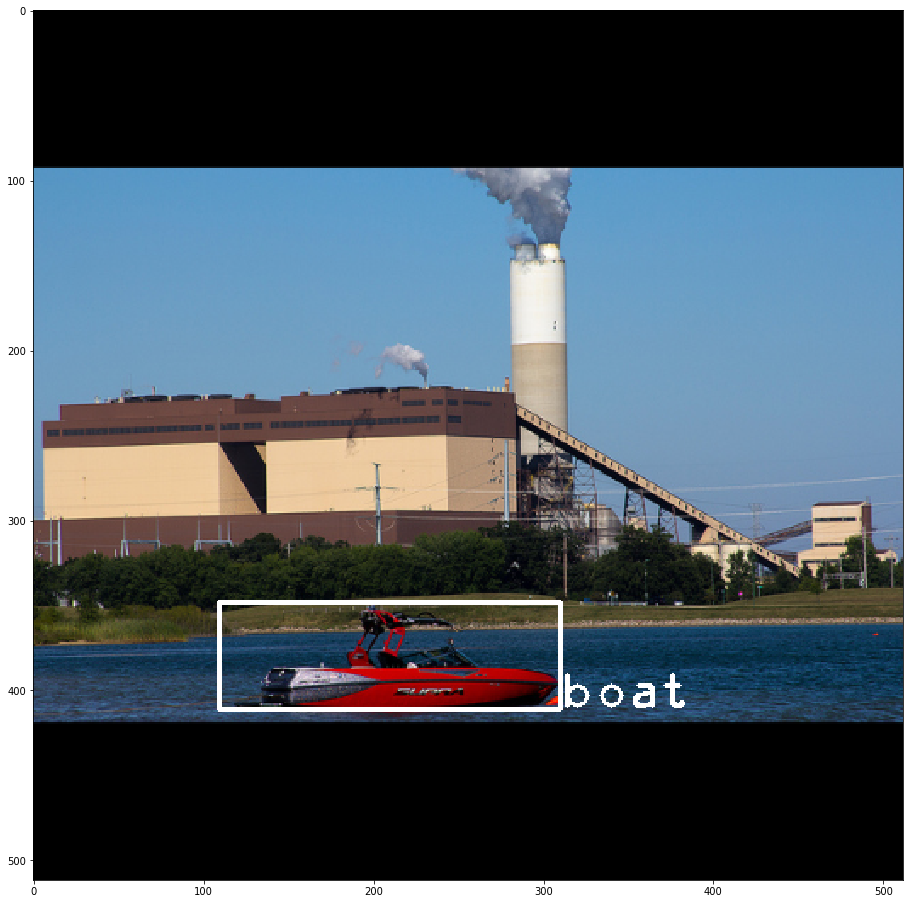

In [56]:
im = batch_images[batch_idx]
im = im.numpy()

fig = plt.figure(figsize=(16,16))
for bbox_index in range(len(predicted_bbox)):
    
    x1,y1,x2,y2 = predicted_bbox[bbox_index]
    cls = predicted_cls[bbox_index]
    cls = index2cat[cls]
    print(cls)
    cv2.rectangle(im, (int(x1), int(y1)), (int(x2), int(y2)), (255, 255, 255), 2)
    cv2.putText(im, cls, (int(x2), int(y2)), font, 2, (255,255,255),2,cv2.LINE_AA, False)
#     cv2.putText(im, cls, (int(x1)+1, int(y1)-14), font, 1, (255,255,0),9, cv2.LINE_AA, False)
    
plt.imshow(im)

In [125]:
cls

'train'

In [49]:
# 2: 'car',
#  3: 'motorcycle',
#  5: 'bus',
#  6: 'train',
#  7: 'truck',
#  8: 'boat',
new_cat = {2:0,3:1,5:2,6:3,7:4,8:5}
index2cat = {0:'car',1:'motorcycle',2:'bus',3:'train',4:'truck',5:'boat'}